In [1]:
import boto3
import json
import pandas as pd
import plotly.express as ex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from io import StringIO
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
def get_secret():
    secret_name = "s3_data_analysis"
    region_name = "us-east-1"

    # Create a Secrets Manager client with default credentials
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        # Retrieve the secret value from Secrets Manager
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    # Extract the secret string (which is a JSON object)
    secret = get_secret_value_response['SecretString']
    
    # Parse the secret string as JSON
    secrets = json.loads(secret)
    
    # Retrieve AWS credentials from the secrets
    aws_access_key_id = secrets['aws_access_key_id']
    aws_secret_access_key = secrets['aws_secret_access_key']
    
    # Now use the retrieved credentials to create the S3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )

    return s3_client

s3_client = get_secret()

In [3]:
init_notebook_mode(connected=True)

In [4]:
def read_csv_from_s3(bucket_name, key, s3_client):
    
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        data = StringIO(csv_content)
        df = pd.read_csv(data)
        return df
    except Exception as e:
         print(f"Error reading CSV from S3: {e}")
         return None

bucket_name = 'nk.data.analysis'
key = 'Hotel_Analysis/hotel_bookings.csv'

df = read_csv_from_s3(bucket_name, key, s3_client)

In [5]:
filter1 = (df['children']==0) & (df['adults']==0) & (df['babies']==0)

In [6]:
df2 = df[~filter1]

In [7]:
data = df2.drop_duplicates()

In [8]:
for col in ['lead_time', 'total_of_special_requests', 'adr']:
    print('feature name: {}'.format(col))

    for i in range(90,101,1):
        quantile_value = np.quantile(data[col], q=i/100)
        print('{}th quantile value is {}'.format(i, quantile_value))
    print('\n')

feature name: lead_time
90th quantile value is 204.0
91th quantile value is 212.0
92th quantile value is 220.0
93th quantile value is 230.0
94th quantile value is 241.0
95th quantile value is 256.0
96th quantile value is 272.0
97th quantile value is 291.0
98th quantile value is 315.0
99th quantile value is 347.0
100th quantile value is 737.0


feature name: total_of_special_requests
90th quantile value is 2.0
91th quantile value is 2.0
92th quantile value is 2.0
93th quantile value is 2.0
94th quantile value is 2.0
95th quantile value is 2.0
96th quantile value is 2.0
97th quantile value is 3.0
98th quantile value is 3.0
99th quantile value is 3.0
100th quantile value is 5.0


feature name: adr
90th quantile value is 174.0
91th quantile value is 179.0
92th quantile value is 185.0
93th quantile value is 190.0
94th quantile value is 197.1
95th quantile value is 204.13300000000018
96th quantile value is 213.0
97th quantile value is 225.0
98th quantile value is 239.0
99th quantile value is

In [9]:
not_canceled = data[data['is_canceled']==0]

In [10]:
country_wise_data = not_canceled['country'].value_counts().reset_index()

In [11]:
country_wise_data.columns = ['country', 'num of guests']

In [12]:
guest_map = ex.choropleth(data_frame = country_wise_data,
             locations = country_wise_data['country'],
             color = country_wise_data['num of guests'],
             hover_name = country_wise_data['country'],
             title = 'Home country of guests')

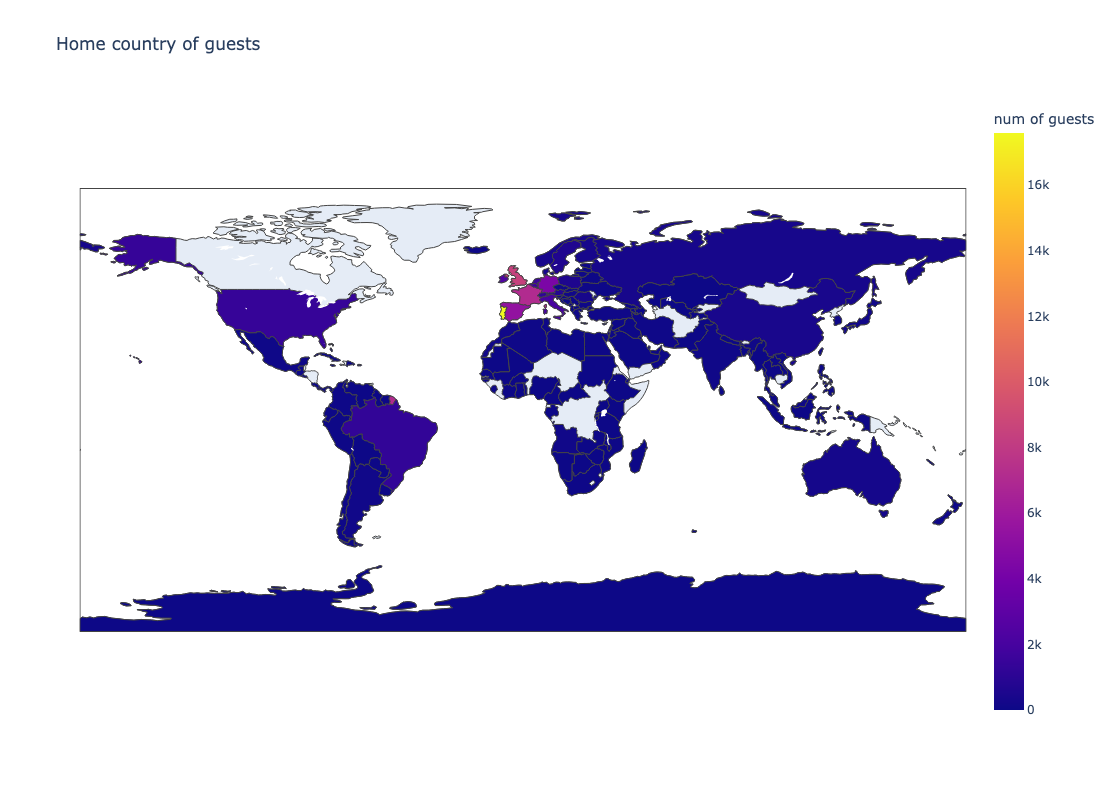

In [13]:
guest_map.update_layout(width=1000, height=800)
guest_map.show()

In [14]:
pivot_normalize = pd.crosstab(index=data['reserved_room_type'], columns=data['assigned_room_type'], margins=True, normalize='index').round(2)*100

In [15]:
market_segment = data['market_segment'].value_counts()

In [16]:
fig = ex.pie(data, 
       values=data['market_segment'].value_counts().values, 
       names=data['market_segment'].value_counts().index)

In [17]:
fig.show()

<Axes: xlabel='market_segment', ylabel='adr'>

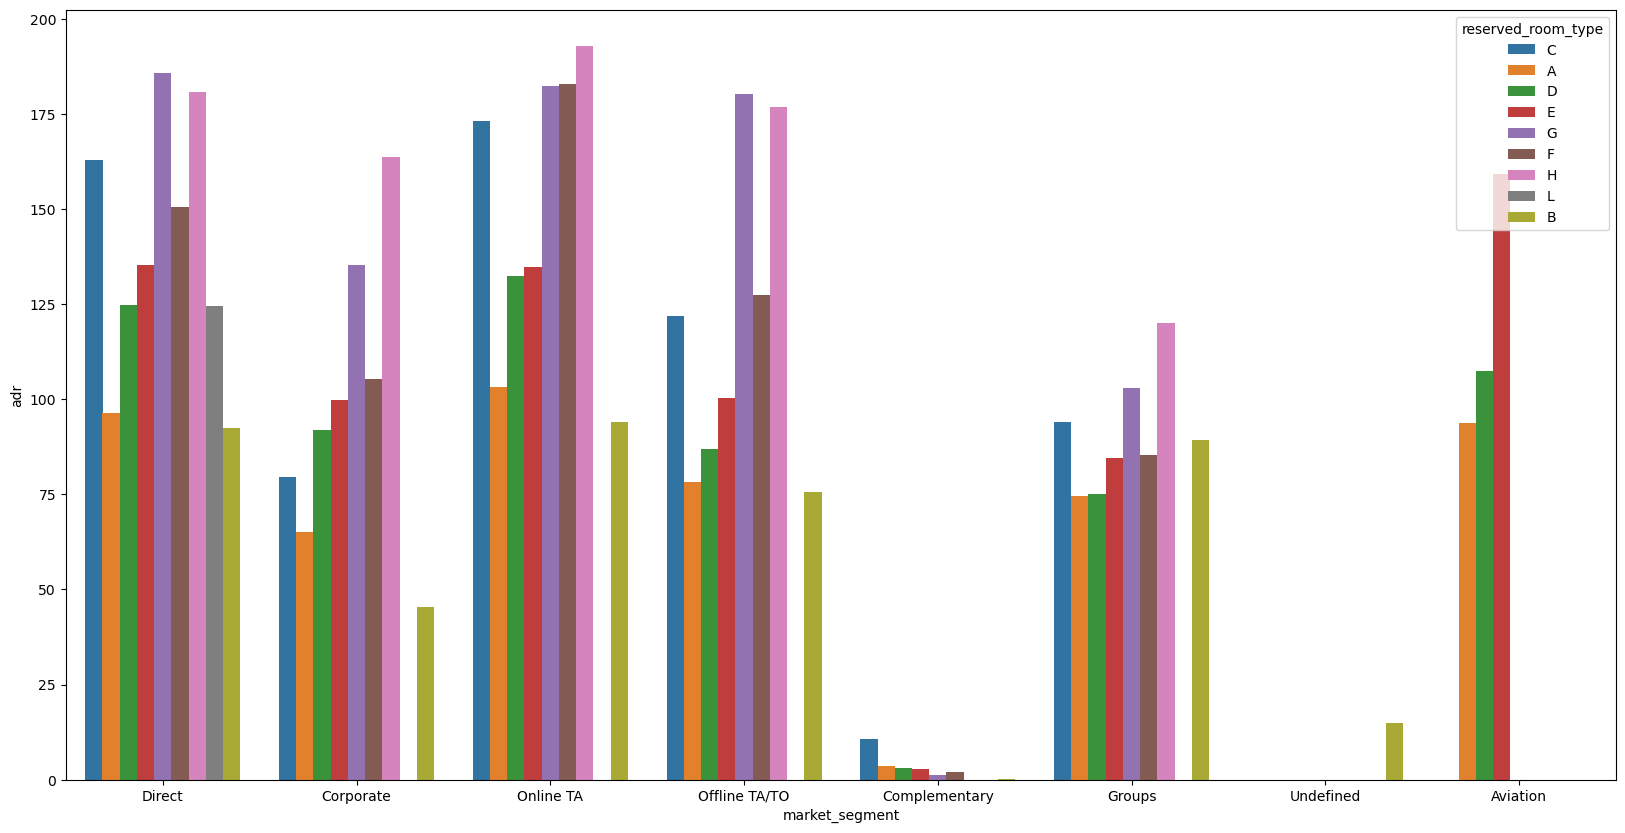

In [18]:
plt.figure(figsize=(20,10))
sb.barplot(x='market_segment', y='adr', data=data, errorbar=None, hue='reserved_room_type')

In [19]:
dict_months = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,
       'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6}

In [20]:
data['arrival_date_month_index'] = data['arrival_date_month'].map(dict_months)

/var/folders/y5/1kb0xnvn7qs44p7ndk6g7xnw0000gn/T/ipykernel_41008/3853447975.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
data['arrival_date'] = data['arrival_date_year'].astype(str) + '-' + data['arrival_date_month_index'].astype(str) + '-' + data['arrival_date_day_of_month'].astype(str)

/var/folders/y5/1kb0xnvn7qs44p7ndk6g7xnw0000gn/T/ipykernel_41008/3239472799.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
data['total_guests'] = data['adults'] +  data['children'] + data['babies']

/var/folders/y5/1kb0xnvn7qs44p7ndk6g7xnw0000gn/T/ipykernel_41008/1475413629.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
filtered_data = data[data['is_canceled']==0]

In [24]:
guest_arrival_series = filtered_data.groupby(['arrival_date'])['total_guests'].sum()

<Axes: xlabel='arrival_date'>

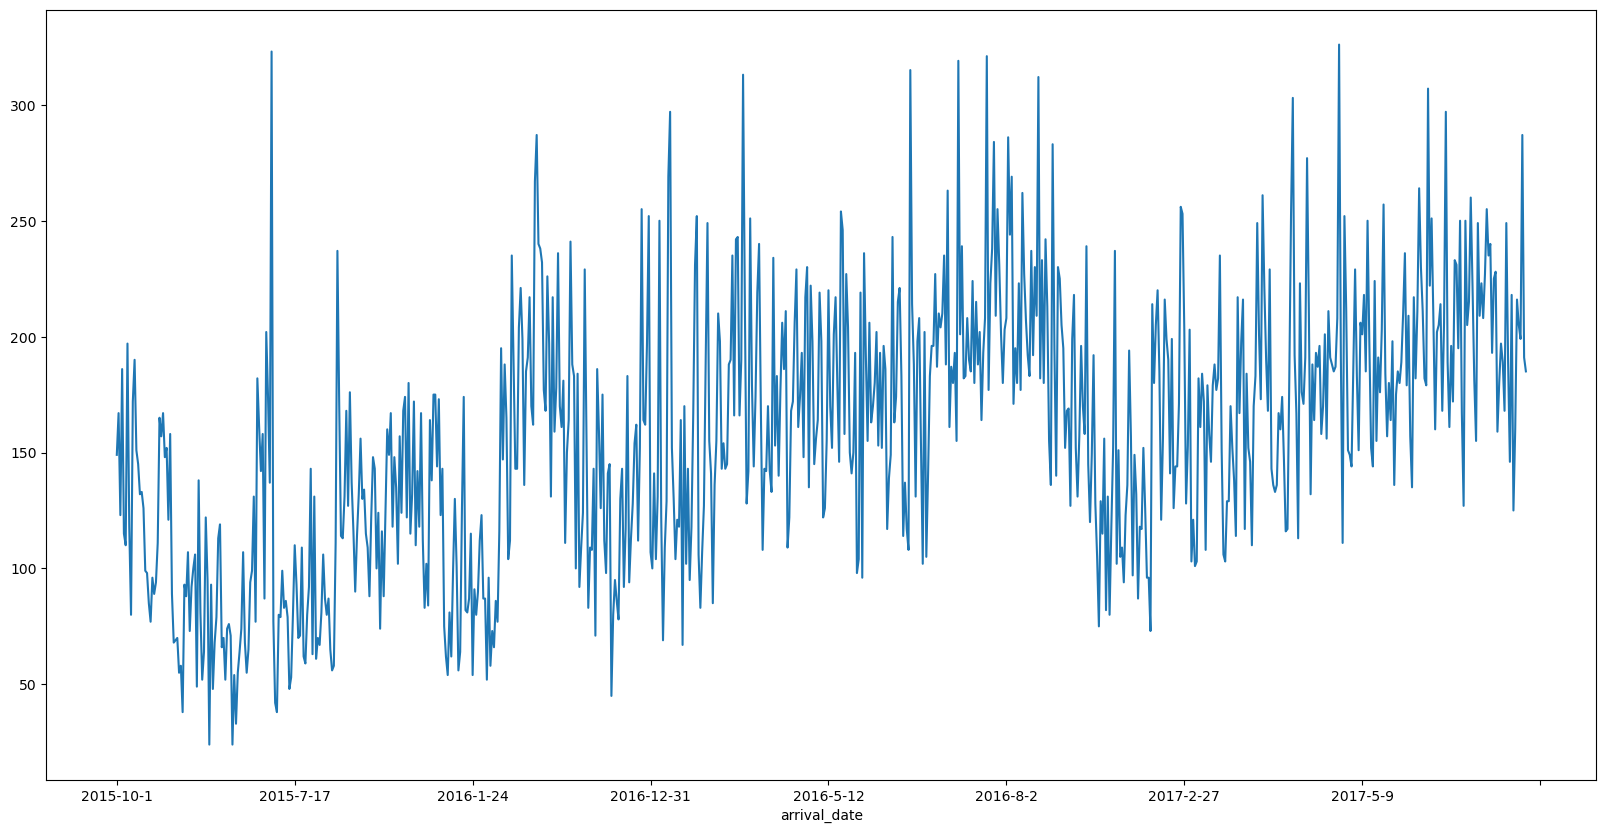

In [25]:
guest_arrival_series.plot(figsize=(20,10))

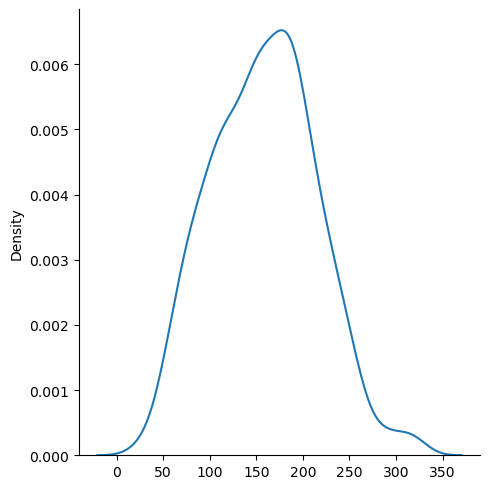

In [26]:
sb.displot(guest_arrival_series.values, kind='kde')

In [27]:
np.mean(guest_arrival_series.values)

157.92559899117276

In [28]:
np.median(guest_arrival_series.values)

158.0

In [29]:
np.std(guest_arrival_series.values)

56.48263702610786